In [1]:
from database.market import Market
from database.sec import SEC
from database.adatabase import ADatabase
import pandas as pd
import matplotlib.pyplot as plt
from processor.processor import Processor as p
from statistics import variance
from tqdm import tqdm
from modeler.modeler import Modeler as m
from datetime import datetime, timedelta

In [2]:
market = Market()

In [3]:
market.connect()
prices = market.retrieve("prices")
market.disconnect()

In [4]:
datasets = {}
for strat in ["econ","speculation"]:
    strat_db = ADatabase(f"strategy_{strat}")
    strat_db.connect()
    sim = strat_db.retrieve("sim")
    strat_db.disconnect()
    strat_factors = [x for x in sim.columns if "prediction" in x or "score" in x]
    for factor in strat_factors:
        sim.rename(columns={factor:factor+f"_{strat}"},inplace=True)
    datasets[strat] = sim

In [5]:
econ = datasets["econ"][[x for x in datasets["econ"].columns if "econ" in x or x in ["year","quarter"]]]
speculation = datasets["speculation"]

In [6]:
quarterly_set = econ.copy()

In [7]:
prices = p.column_date_processing(prices)
prices["year"] = [x.year for x in prices["date"]]
prices["week"] = [x.week for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]

In [8]:
weekly_set = prices.merge(speculation,on=["year","week","ticker"]).dropna()

In [10]:
data = weekly_set.merge(quarterly_set,on=["year","quarter"]).groupby(["year","week","ticker"]).mean().reset_index()

In [11]:
data

,year,week,ticker,close,high,low,open,volume,adjclose,adjhigh,...,xgb_prediction_speculation,xgb_score_speculation,cat_prediction_speculation,cat_score_speculation,skl_prediction_econ,skl_score_econ,xgb_prediction_econ,xgb_score_econ,cat_prediction_econ,cat_score_econ
0,2003,1,A,24.944,25.10020,24.3820,24.480,1864600.0,16.458426,16.561489,...,16.014189,0.994941,13.777477,0.984580,40.457337,0.937191,52.780971,0.907234,64.540750,0.968703
1,2003,1,AAPL,18.700,18.80800,18.4260,18.520,3363020.0,0.286264,0.287917,...,0.293517,0.998739,0.245865,0.967587,40.457337,0.937191,52.780971,0.907234,64.540750,0.968703
2,2003,1,ABC,59.822,61.74200,58.9700,60.778,2905280.0,11.709222,12.085250,...,11.947840,0.998134,11.574454,0.994288,40.457337,0.937191,52.780971,0.907234,64.540750,0.968703
3,2003,1,ABMD,5.758,5.85000,5.5766,5.684,60620.0,5.758000,5.850000,...,5.399693,0.997396,4.683098,0.974991,40.457337,0.937191,52.780971,0.907234,64.540750,0.968703
4,2003,1,ABT,44.162,44.45000,43.8120,44.028,10930260.0,12.046196,12.124531,...,12.001316,0.992994,11.645779,0.979023,40.457337,0.937191,52.780971,0.907234,64.540750,0.968703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417371,2021,52,XLNX,221.525,223.83500,217.0250,220.390,2879817.5,221.525000,223.835000,...,150.495880,0.993721,134.006986,0.978200,489.751001,0.961143,334.148285,0.922918,247.196367,0.914868
417372,2021,52,XOM,61.342,61.78566,60.8400,61.256,12811512.0,61.342000,61.785660,...,62.007320,0.996774,62.007456,0.988432,489.751001,0.961143,334.148285,0.922918,247.196367,0.914868
417373,2021,52,XRAY,56.124,56.56200,55.7630,56.045,969413.0,56.101867,56.539777,...,55.702221,0.993853,53.082276,0.965062,489.751001,0.961143,334.148285,0.922918,247.196367,0.914868
417374,2021,52,XYL,118.905,119.15765,117.9450,118.090,619819.5,118.905000,119.157650,...,99.077568,0.991850,89.385768,0.971950,489.751001,0.961143,334.148285,0.922918,247.196367,0.914868


In [12]:
final = []
for ticker in tqdm(data["ticker"].unique()):
    ticker_data = data[data["ticker"]==ticker]
    ticker_data["y"] = ticker_data["adjclose"].shift(-1)
    final.append(ticker_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 478/478 [00:11<00:00, 41.38it/s]


In [13]:
stuff = pd.concat(final)

In [14]:
stuff

,year,week,ticker,close,high,low,open,volume,adjclose,adjhigh,...,xgb_score_speculation,cat_prediction_speculation,cat_score_speculation,skl_prediction_econ,skl_score_econ,xgb_prediction_econ,xgb_score_econ,cat_prediction_econ,cat_score_econ,y
0,2003,1,A,24.9440,25.1002,24.38200,24.4800,1864600.00,16.458426,16.561489,...,0.994941,13.777477,0.984580,40.457337,0.937191,52.780971,0.907234,64.540750,0.968703,12.936333
356,2003,2,A,19.6060,19.9720,19.11800,19.3940,2978960.00,12.936333,13.177826,...,0.994941,13.280141,0.984580,55.195736,0.937191,65.675262,0.907234,61.724783,0.968703,12.554960
712,2003,3,A,19.0280,19.6420,18.80400,19.4300,2091040.00,12.554960,12.960087,...,0.994941,12.136126,0.984580,55.195736,0.937191,65.675262,0.907234,61.724783,0.968703,11.411501
1068,2003,4,A,17.2950,17.9125,17.21500,17.7450,2250700.00,11.411501,11.818937,...,0.994941,11.130809,0.984580,55.195736,0.937191,65.675262,0.907234,61.724783,0.968703,10.880350
1424,2003,5,A,16.4900,16.8440,16.07000,16.4040,1967120.00,10.880350,11.113924,...,0.994941,12.601813,0.984580,55.195736,0.937191,65.675262,0.907234,61.724783,0.968703,9.609546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415255,2021,48,LIN,320.3740,324.1860,318.06300,321.7480,2462259.00,319.749746,323.553874,...,0.993125,250.498702,0.943603,489.751001,0.961143,334.148285,0.922918,247.196367,0.914868,330.998000
415731,2021,49,LIN,330.9980,332.3640,329.51600,330.7480,1408728.40,330.998000,332.364000,...,0.993125,250.980370,0.943603,489.751001,0.961143,334.148285,0.922918,247.196367,0.914868,336.778000
416207,2021,50,LIN,336.7780,339.0540,334.15200,336.8180,1666889.00,336.778000,339.054000,...,0.993125,248.584590,0.943603,489.751001,0.961143,334.148285,0.922918,247.196367,0.914868,334.432500
416683,2021,51,LIN,334.4325,335.2150,330.81125,332.0625,1187291.25,334.432500,335.215000,...,0.993125,252.924823,0.943603,489.751001,0.961143,334.148285,0.922918,247.196367,0.914868,344.674000


In [16]:
factors = [x for x in stuff.columns if x == "adjclose" or "prediction" in x or "score" in x]
factors

['adjclose',
 'skl_prediction_speculation',
 'skl_score_speculation',
 'xgb_prediction_speculation',
 'xgb_score_speculation',
 'cat_prediction_speculation',
 'cat_score_speculation',
 'skl_prediction_econ',
 'skl_score_econ',
 'xgb_prediction_econ',
 'xgb_score_econ',
 'cat_prediction_econ',
 'cat_score_econ']

In [27]:
# sim = []
for year in tqdm(range(2021,2022)):
    try:
        training_set = stuff[(stuff["year"]<year) & (stuff["year"]>=year-7)].dropna().reset_index()
        prediction_set = stuff[stuff["year"]==year].dropna()
        refined_data = {"X":training_set[factors],"y":training_set[["y"]]}
        models = m.regression(refined_data)
        for row in models.iterrows():
            try:
                model = row[1]["model"]
                api = row[1]["api"]
                score = row[1]["score"]
                prediction_set[f"{api}_prediction"] = model.predict(prediction_set[factors])
                prediction_set[f"{api}_score"] = score
            except:
                print(training_set.index.size)
                continue
        prediction_set["prediction"] = (prediction_set["skl_prediction"] + prediction_set["xgb_prediction"] + prediction_set["cat_prediction"]) / 3
        cleaned_set = prediction_set[["year","week","ticker","prediction"]]
        sim.append(cleaned_set)
    except Exception as e:
        print(year,str(e))
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:16<00:00, 76.54s/it]


In [28]:
simulation = prices.merge(pd.concat(sim),on=["year","week","ticker"],how="left")

In [29]:
simulation["delta"] = (simulation["prediction"] - simulation["adjclose"]) / simulation["adjclose"]

In [44]:
simulation.dropna()

,date,close,high,low,open,volume,adjclose,adjhigh,adjlow,adjopen,adjvolume,divcash,splitfactor,ticker,year,week,quarter,prediction,delta
4030,2010-01-04,83.02,83.45,82.67,83.09,3043700,59.846007,60.155978,59.593705,59.896467,3043700,0.0,1.0,MMM,2010,1,1,60.394150,0.009159
4031,2010-01-05,82.50,83.23,81.70,82.80,2847000,59.471158,59.997388,58.894468,59.687417,2847000,0.0,1.0,MMM,2010,1,1,60.394150,0.015520
4032,2010-01-06,83.67,84.60,83.51,83.88,5268500,60.314567,60.984969,60.199229,60.465948,5268500,0.0,1.0,MMM,2010,1,1,60.394150,0.001319
4033,2010-01-07,83.73,83.76,82.12,83.32,4470100,60.357819,60.379445,59.197230,60.062265,4470100,0.0,1.0,MMM,2010,1,1,60.394150,0.000602
4034,2010-01-08,84.32,84.32,83.30,83.69,3405800,60.783128,60.783128,60.047848,60.328985,3405800,0.0,1.0,MMM,2010,1,1,60.394150,-0.006399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2882062,2021-12-17,131.93,133.84,131.83,133.41,2492723,131.930000,133.840000,131.830000,133.410000,2492723,0.0,1.0,YUM,2021,50,4,123.077768,-0.067098
2882063,2021-12-20,131.57,131.72,130.12,130.69,1155432,131.570000,131.720000,130.120000,130.690000,1155432,0.0,1.0,YUM,2021,51,4,123.783965,-0.059178
2882064,2021-12-21,133.37,134.49,132.19,132.39,1202380,133.370000,134.490000,132.190000,132.390000,1202380,0.0,1.0,YUM,2021,51,4,123.783965,-0.071875
2882065,2021-12-22,134.63,135.14,133.50,133.62,940073,134.630000,135.140000,133.500000,133.620000,940073,0.0,1.0,YUM,2021,51,4,123.783965,-0.080562


In [60]:
positions = 10
start_date = datetime(2010,1,1)
end_date = datetime(2022,1,1)
reqs = [1,3,5]
limit = 7
values = [True]
trades = []
for value in tqdm(values):
    for req in tqdm(reqs):
        for position in range(positions):
            date = start_date
            iterration_sim = simulation.copy()
            while date < end_date:
                try:
                    todays_recs = iterration_sim[iterration_sim["date"]==date]
                    todays_recs.sort_values("delta",ascending=False,inplace=True)
                    if todays_recs.index.size > 0:
                        offering = todays_recs.iloc[position]
                        if offering["delta"] > req / 100:
                            trade = offering
                            ticker = trade["ticker"]
                            buy_price = trade["adjclose"]
                            exits = iterration_sim[(iterration_sim["ticker"]==ticker) & (iterration_sim["date"]>date)].iloc[:limit]
                            exits["gains"] = (exits["adjclose"] - buy_price) / buy_price
                            exit = exits.sort_values("gains",ascending=False).iloc[0]
                            trade["sell_price"] = exit["adjclose"]
                            trade["sell_date"] = exit["date"]
                            date = exit["date"] + timedelta(days=1)
                            trade["value"] = value
                            trade["req"] = req
                            trade["position"] = position
                            trades.append(trade)
                        else:
                            date = date + timedelta(days=1)
                    else:
                        date = date + timedelta(days=1)
                except Exception as e:
                    print(str(e))
                    date = date+timedelta(days=1)

  0%|                                                                                                                                                                                    | 0/1 [33:31<?, ?it/s]


KeyboardInterrupt: 

In [62]:
t = pd.DataFrame(trades)

In [63]:
t["delta"] =  (t["sell_price"] - t["close"]) / t["close"]

In [64]:
analysis = []
for value in tqdm(values):
    for req in tqdm(reqs):
        for position in range(positions):
            position_trades = t[(t["value"]==value) & (t["req"]==req) & (t["position"]==position)].sort_values("date")
            position_trades["delta"] = (position_trades["sell_price"] - position_trades["adjclose"]) / position_trades["adjclose"]
            initial = 100 / positions
            for delta in position_trades["delta"]:
                initial = initial * (1+delta)
            analysis.append({
                "value":value,
                "req":req,
                "position":position,
                "pv":initial
            })

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


In [65]:
complete = pd.DataFrame(analysis).pivot_table(index=["value","req"],columns="position",values="pv").reset_index()

In [66]:
complete["pv"] = [sum([row[1][i] for i in range(positions)]) for row in complete.iterrows()]

In [67]:
complete.sort_values("pv",ascending=False)

position,value,req,0,1,2,3,4,5,6,7,8,9,pv
0,True,1,2.796539e+08,3.764892e+10,1.288083e+11,7.343930e+10,6.373373e+11,1.310714e+11,5.563458e+10,6.188186e+10,1.174270e+11,2.353544e+11,1.478883e+12
1,True,3,2.796539e+08,2.564599e+10,1.071215e+11,8.685386e+10,3.333916e+11,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,5.532926e+11
2,True,5,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+02


In [68]:
best_iteration = t[(t["value"]==True) & (t["req"]==1)].copy()

In [69]:
pivoted = best_iteration.pivot_table(index="date",columns="position",values="delta").fillna(0)

In [70]:
for i in range(positions):
    pv = []
    initial = 100/positions
    for delta in pivoted[i]:
        initial = initial * (1+delta)
        pv.append(initial)
    pivoted[f"pv_{i}"] = pv

In [71]:
pivoted["pv"] = [sum([row[1][f"pv_{i}"] for i in range(positions)]) for row in pivoted.iterrows()]

In [72]:
pivoted.reset_index(inplace=True)

In [74]:
pivoted

position,date,0,1,2,3,4,5,6,7,8,...,pv_1,pv_2,pv_3,pv_4,pv_5,pv_6,pv_7,pv_8,pv_9,pv
0,2010-01-04,0.011609,-0.142232,0.167368,-0.166052,-0.208926,0.146030,0.017545,-0.794260,0.201800,...,8.577678e+00,1.167368e+01,8.339478e+00,7.910739e+00,1.146030e+01,1.017545e+01,2.057397e+00,1.201800e+01,7.434521e+00,8.976334e+01
1,2010-01-06,-0.000776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.577678e+00,1.167368e+01,8.339478e+00,7.910739e+00,1.146030e+01,1.017545e+01,2.057397e+00,1.201800e+01,7.434521e+00,8.975549e+01
2,2010-01-08,0.000000,-0.177575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.054496e+00,1.167368e+01,8.339478e+00,7.910739e+00,1.146030e+01,1.017545e+01,2.057397e+00,1.201800e+01,7.809264e+00,8.860705e+01
3,2010-01-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.740528,0.000000,...,7.054496e+00,1.167368e+01,8.339478e+00,7.910739e+00,1.146030e+01,1.017545e+01,5.338361e-01,1.201800e+01,7.809264e+00,8.708349e+01
4,2010-01-12,0.001495,-0.158168,0.065054,0.014116,-0.030292,-0.498987,0.000000,0.000000,0.000000,...,5.938699e+00,1.243311e+01,8.457200e+00,7.671103e+00,5.741762e+00,1.017545e+01,5.338361e-01,1.201800e+01,7.809264e+00,8.090177e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,2021-12-16,0.000000,0.000000,0.000000,0.000000,0.078125,0.000000,0.000000,0.000000,0.000000,...,3.567012e-27,1.698592e-21,2.500122e-37,4.015849e-30,8.506474e-40,1.593138e-39,3.614671e-39,2.297946e-49,1.594690e-39,1.698595e-21
2077,2021-12-17,0.000000,0.036962,0.000000,0.000000,0.000000,0.000000,0.000000,0.093805,0.000000,...,3.698857e-27,1.698592e-21,2.500122e-37,4.015849e-30,8.506474e-40,1.593138e-39,3.953746e-39,2.297946e-49,1.594690e-39,1.698596e-21
2078,2021-12-20,0.028846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.698857e-27,1.698592e-21,2.500122e-37,4.015849e-30,8.506474e-40,1.593138e-39,3.953746e-39,2.297946e-49,1.594690e-39,1.698596e-21
2079,2021-12-22,0.000000,0.000000,0.037942,0.000000,0.000000,0.062137,0.063547,0.000000,0.000000,...,3.698857e-27,1.763040e-21,2.500122e-37,4.015849e-30,9.035041e-40,1.694376e-39,3.953746e-39,2.297946e-49,1.594690e-39,1.763044e-21


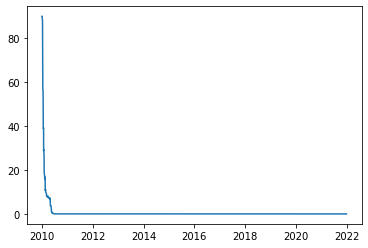

In [73]:
plt.plot(pivoted["date"],pivoted["pv"])